In [19]:
import numpy as np
import math
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt


In [20]:
class Galerkin:

  def __init__(self, x, f, exact_solution, p, q, variable_sized_mesh = False):
    self.x = x                  # x nodal points in mesh
    self.M = len(x)-1   
    self.h = None   
    self.p = p
    self.q = q  
    self.f = f                  # Right side f(x) function
    self.exact_sol = exact_solution   # Exact solution of the differential equation

    # Calculate h(step) for:
      # - Variable sized subintervals
      # - Equal sized subintervals
    if variable_sized_mesh:
      self.h = []
      for i in range(self.M):
          self.h.append(self.x[i+1] - self.x[i])
    else:
      self.h = self.x[1] - self.x[0]
    
    
  # Simpsons 1/3 rule
  def simps(self, w, ll, ul, n):

    # Calculating the value of h
    h = ( ul - ll )/n

 
    # List for storing value of x and f(x)
    x = list()
    fx = list()
     
    # Calculate values of x and f(x)
    i = 0
    while i<= n:
        x.append(ll + i * h)
        fx.append(self.f(x[i]) * w(x[i]))
        i += 1
 
    # Calculate result
    res = 0
    i = 0
    while i<= n:
        if i == 0 or i == n:
            res+= fx[i]
        elif i % 2 != 0:
            res+= 4 * fx[i]
        else:
            res+= 2 * fx[i]
        i+= 1
    res = res * (h / 3)
    return res

  def gauss_elimination(self,A, F):
    n = len(F) #n is matrix size

    #Elimination phase
    for k in range(0,n-1): #k is matrix row
        for i in range(k+1,n): #i is matrix col
                  if A[i,k] != 0.0:
                    factor = A[i,k]/A[k,k]
                    A[i,k+1:n] = A[i,k+1:n] - np.multiply(factor,A[k,k+1:n])
                    F[i] = F[i] - np.multiply(factor,F[k])

    #Back substitution
    for k in range(n-1,-1,-1):
          F[k] = (F[k] - np.dot(A[k,k+1:n],F[k+1:n]))/A[k,k]

    return F

  # Hat function 1
  def hat_function_1(self, x1, x2):
    return lambda x: (x - x1)/(x2 - x1) 

  # Hat function 2
  def hat_function_2(self, x1, x2):
    return lambda x: (x2 - x)/(x2 - x1)


  def load_vector_elem_integral(self, x1, x2, hat_func):
    if hat_func == 1:
      w = self.hat_function_1(x1, x2)   # w = φi(x) 
      return self.simps(w, x1, x2, 2)
    else:
      w = self.hat_function_2(x1, x2)
      return self.simps(w, x1, x2, 2)

  # Global stiffness matrix 
  def global_stiffness_matrix(self, px, qx, y0, ye):

    A = csr_matrix((self.M+1, self.M+1), dtype = np.float64).toarray()
    F = np.zeros(self.M+1, dtype = np.float64)

    """
    #------ For 1D models: -u''(x) = f(x)

    A[0][0] = 1;      F[0] = 0
    A[self.M-1][self.M-1] = 1;  F[self.M-1] = 0
    A[1][1] = 1/h[0]; F[1] = self.load_vector_elem_integral(self.x[0], self.x[1], 1)


    for i in range(1, M-2):
      A[i][i] += 1/h[i]
      A[i][i+1] -= 1/h[i]
      A[i+1][i] -= 1/h[i]
      A[i+1][i+1] += 1/h[i]

      F[i] += self.load_vector_elem_integral(self.x[i], self.x[i+1], 2)
      F[i+1] += self.load_vector_elem_integral(self.x[i], self.x[i+1], 1)

    A[self.M-2][self.M-2] += 1/h[self.M-2]
    F[self.M-2] += self.load_vector_elem_integral(self.x[self.M-2], self.x[self.M-1], 2)
    """

    # Global stiffness matrix
    A[0][0] = 1.; A[self.M][self.M] = 1.
    for i in range(1, self.M):
      for j in range(0, self.M):
        if i == j:
          A[i][j] = self.p(px)*(2./h) + self.q(qx)*((2./3.)*h)
        elif i == j-1 or i == j+1:
          A[i][j] = self.p(px)*(-(1./h)) + self.q(qx)*(h/6.)
        else:
          A[i][j] = 0.


    # Global load vector
    # Boundary condition apply u(x0) = y0
    F[0] = y0

    # Boundary condition apply u(xn) = ye
    F[self.M] = ye

    F[1] = self.load_vector_elem_integral(self.x[0], self.x[1], 1)
    for i in range(1, self.M-1):
      # Local load vector
      F[i] += self.load_vector_elem_integral(self.x[i], self.x[i+1], 2)
      F[i+1] += self.load_vector_elem_integral(self.x[i], self.x[i+1], 1)

    F[self.M-1] += self.load_vector_elem_integral(self.x[self.M-1], self.x[self.M], 2)

    return self.gauss_elimination(A, F)

  # Φi(x) calculation
  def phi(self, xp, i):
    if self.x[i-1] <= xp <= self.x[i]:
      return (xp - self.x[i-1])/(self.x[i] - self.x[i-1])

    elif self.x[i] <= xp <= self.x[i+1]:
      return (self.x[i+1] - xp)/(self.x[i+1] - self.x[i])

    return 0

  # Galerkin finite element solution approximation
  def fem_solution(self, U, xp):
    ux = 0
    for i in range(1, self.M):
      ux += U[i] * self.phi(xp, i)
    return ux

  # Plot functions
  def plot_functions(self, u_exact, u_fem, xps):
    fig, axs = plt.subplots(3, sharex=True, sharey=True)
    fig.suptitle('u(x) is blue u_fem(x) is red')

    axs[0].plot(xps, u_exact)   # Exact solution 

    axs[1].plot(xps, u_fem, 'tab:red')    # Approximate solution

    axs[2].plot(xps, u_exact)
    axs[2].plot(xps, u_fem, 'tab:red')



  # Compare exact and approximate solutions
  def compare_solutions(self, xps, U):
    u_exact = []    # Array to store exact solutions at nodal points 'xps'
    u_fem = []      # Array to store approximation solutions at nodal points 'xps'
    error_arr = []
    x = sp.Symbol("x")

    for i in range(len(xps)):
      u_exact.append(self.exact_sol(xps[i]))
      u_fem.append(self.fem_solution(U, xps[i]))
      error_arr.append(abs(u_fem[i] - u_exact[i]))

    error = np.linalg.norm(error_arr, np.inf)
        
    return u_exact, u_fem, error

      
    
  

Error: 6.73131658052162E-10


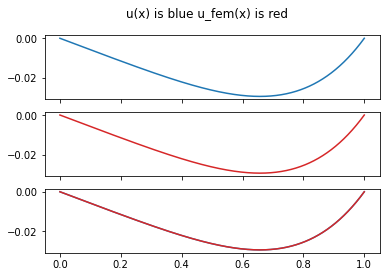

In [21]:
interval = [0,1]
h = 0.0005  # Step size. Reducing the step we get better approximation
x_points = np.arange(interval[0], interval[1] + h, h)     # Initial x nodal points
f = lambda x: x**3    # f(x) function
p = lambda x: x
q = lambda x: x 
exact_solution = lambda x: x**3. - 6.*x + ((5*sp.sin(x)) / math.sin(1))     # Exact solution


model = Galerkin(x_points, f, exact_solution, p, q)
U = model.global_stiffness_matrix(-1., 1., 0., 0.)

exact, fem, err = model.compare_solutions(x_points, U)
print(f'Error: {err}')

model.plot_functions(exact, fem, x_points)   # Plot functions